In [4]:
#!pip install pmdarima
#!pip install pystan==2.19.1.1
#!pip install prophet
#!pip install cmdstanpy==0.9.5

In [5]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pylab import rcParams
import statsmodels.api as sm
import pylab as pl
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

from google.colab import drive

from prophet.diagnostics import cross_validation
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools


In [6]:

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = "/content/drive/MyDrive/Colab Notebooks/SP500_Index.csv"
df_energy = pd.read_csv(path,sep=";")

In [8]:
df_energy.head(5)

,date,clean_energy,energy
0,31/08/2011,842.65,506.52
1,1/09/2011,824.99,502.12
2,2/09/2011,791.99,489.40
3,5/09/2011,776.69,NaN
4,6/09/2011,755.55,483.84


In [9]:
#set date column as date var 
df_energy['date'] = pd.to_datetime(df_energy['date'])
#df_energy = df_energy.set_index('date_')
#df_energy.drop(['date'], axis=1, inplace=True)
df_energy.head()


,date,clean_energy,energy
0,2011-08-31,842.65,506.52
1,2011-01-09,824.99,502.12
2,2011-02-09,791.99,489.40
3,2011-05-09,776.69,NaN
4,2011-06-09,755.55,483.84


## Graphs 

No handles with labels found to put in legend.


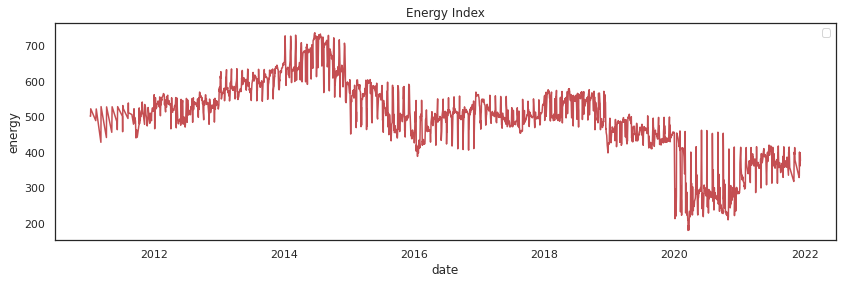

In [10]:
sns.set(rc={'figure.figsize':(14, 4)})
sns.set(style="white")
sns.lineplot(x="date", y="energy", data=df_energy,color="r")
plt.title("Energy Index")
plt.legend()
#plt.savefig('energy.jpg');

No handles with labels found to put in legend.


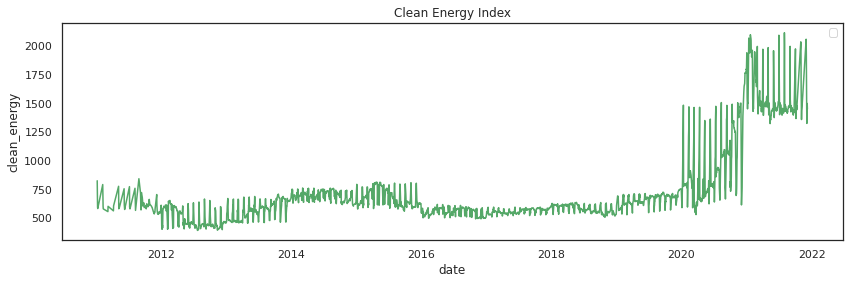

In [11]:
sns.set(rc={'figure.figsize':(14, 4)})
sns.set(style="white")
sns.lineplot(x="date", y="clean_energy", data=df_energy,color="g")
plt.title("Clean Energy Index")
plt.legend()
#plt.savefig('clean.jpg');

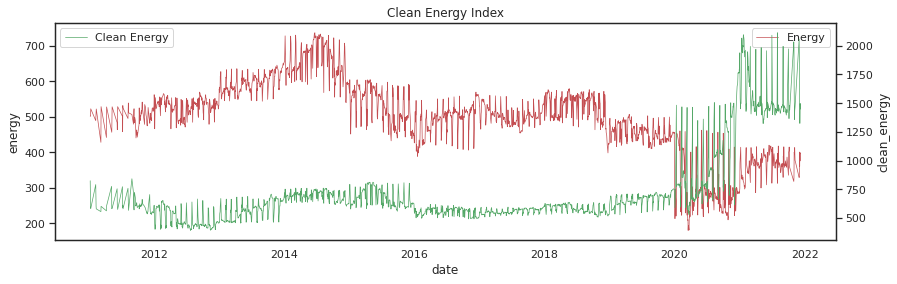

In [12]:
sns.set(rc={'figure.figsize':(14, 4)})
sns.set(style="white")
sns.lineplot(x="date", y="energy", data=df_energy, color="r",linewidth=0.7,label="Energy",legend=False)
plt.legend()
ax2 = plt.twinx()
sns.lineplot(x="date", y="clean_energy", data=df_energy, color="g",linewidth=0.7,label="Clean Energy", ax=ax2,legend=False)
plt.title("Clean Energy Index")
plt.legend()
#plt.savefig('energyVSclean.jpg');


## Understandig behavior 

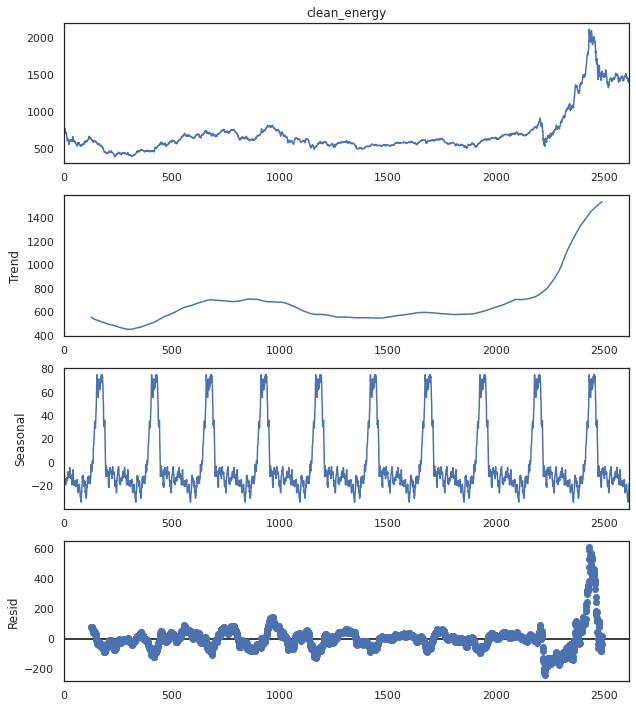

In [13]:
#Time series decomposition Clean energy

rcParams['figure.figsize'] = 9,10
decom = sm.tsa.seasonal_decompose(df_energy['clean_energy'], model='additive', period=253)
fig = decom.plot()
plt.show()

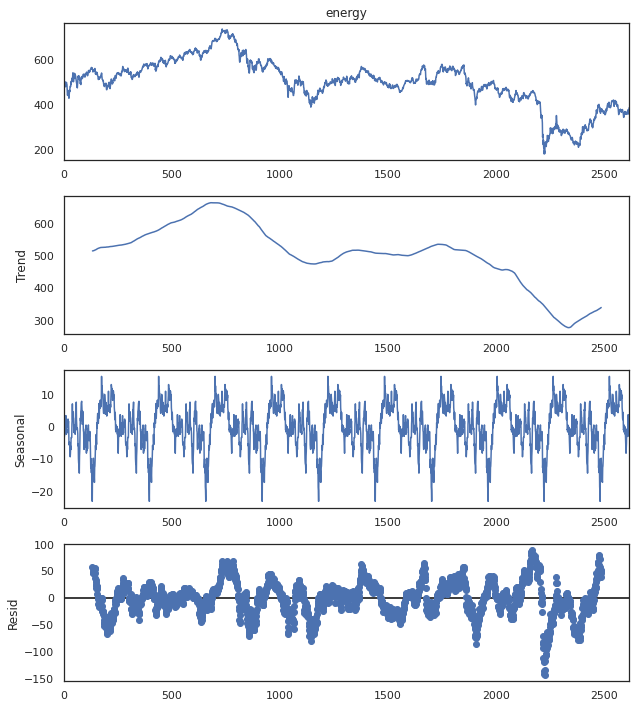

In [14]:
#Time series decomposition  energy
df_energy_=df_energy.dropna(subset = ["energy"], inplace=True)

rcParams['figure.figsize'] = 9,10
decom = sm.tsa.seasonal_decompose(df_energy['energy'], model='additive',period=253)
fig = decom.plot()
plt.show()

In [16]:
#Naming series to model
df_energy['ds'] = pd.to_datetime(df_energy['date'])
df_energy['y'] = df_energy['energy']
df_energy.head()

,date,clean_energy,energy,ds,y
0,2011-08-31,842.65,506.52,2011-08-31,506.52
1,2011-01-09,824.99,502.12,2011-01-09,502.12
2,2011-02-09,791.99,489.40,2011-02-09,489.40
4,2011-06-09,755.55,483.84,2011-06-09,483.84
5,2011-07-09,773.66,501.50,2011-07-09,501.50


In [17]:
df=pd.DataFrame(df_energy[['ds','y']])
df['cap'] = 60000
df['floor'] = 0

In [18]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
   # m.add_country_holidays(country_name='US')
    m.fit(history_df)
    df_cv = cross_validation(m, initial='2000 days', period='180 days', horizon = '90 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

  


In [19]:
  param_grid = {  
                'changepoint_prior_scale': [0.05, 0.5, 5],
               # 'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
               # 'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear', 'logistic'],
                #'yearly_seasonality': [5, 10, 20]
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []



In [18]:
#TUNNING HYPERPARAMETER - TAKE LOOOOONG TO RUN
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df


# The best param combination is {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear'}

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]


 The best param combination is {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear'}


,horizon,rmse,mape,params
0,49 days 12:00:00,69.5571,0.143132,"{'changepoint_prior_scale': 0.05, 'seasonality..."
1,49 days 12:00:00,70.0218,0.150037,"{'changepoint_prior_scale': 0.05, 'seasonality..."
2,49 days 12:00:00,70.8015,0.14527,"{'changepoint_prior_scale': 0.05, 'seasonality..."
3,49 days 12:00:00,71.2401,0.152428,"{'changepoint_prior_scale': 0.05, 'seasonality..."
4,49 days 12:00:00,69.3741,0.142715,"{'changepoint_prior_scale': 0.05, 'seasonality..."
5,49 days 12:00:00,69.4999,0.148424,"{'changepoint_prior_scale': 0.05, 'seasonality..."
6,49 days 12:00:00,70.9245,0.145533,"{'changepoint_prior_scale': 0.05, 'seasonality..."
7,49 days 12:00:00,70.4849,0.150735,"{'changepoint_prior_scale': 0.05, 'seasonality..."
8,49 days 12:00:00,69.4054,0.14285,"{'changepoint_prior_scale': 0.05, 'seasonality..."
9,49 days 12:00:00,69.5698,0.149181,"{'changepoint_prior_scale': 0.05, 'seasonality..."


In [30]:
holidays = pd.DataFrame({
  'holiday': 'covid',
  'ds': pd.to_datetime(['2020-03-09','2021-01-02']),
  'lower_window': 0,
  'upper_window': 1,
})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


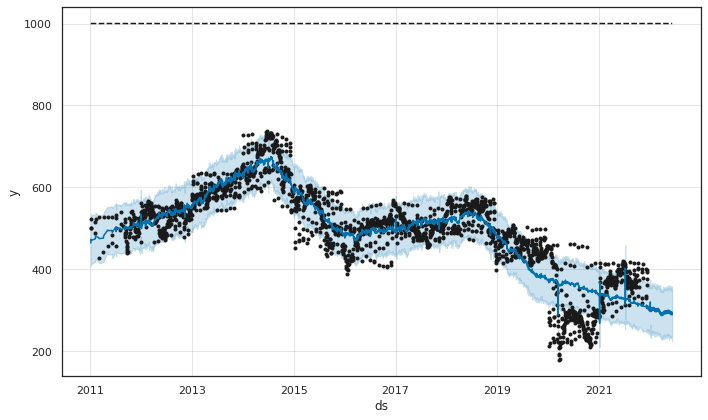

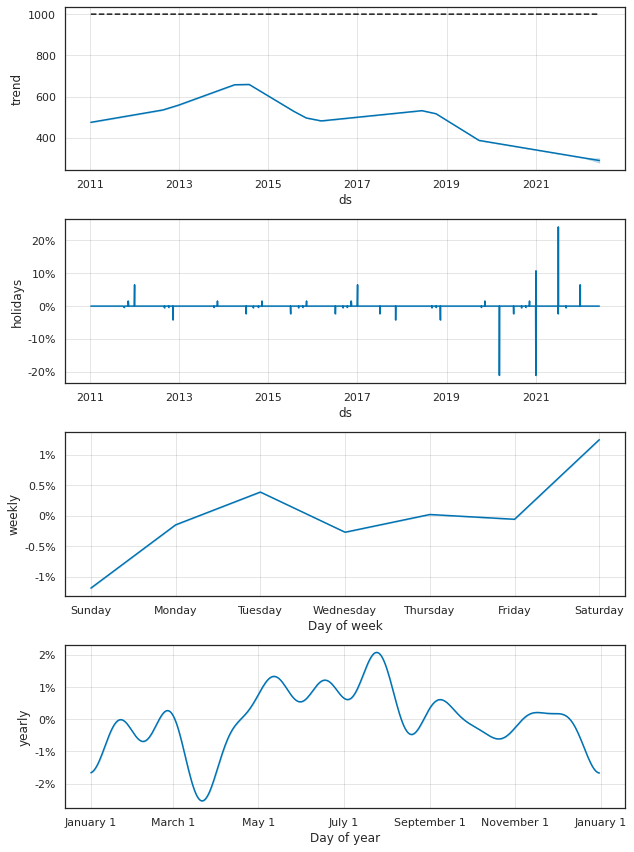

In [36]:
m= Prophet(
    changepoint_prior_scale=0.05,
  #  changepoint_range=0.8,
    seasonality_prior_scale=1,
    holidays_prior_scale= 2.5,
    seasonality_mode='multiplicative',
    growth='linear', 
   # yearly_seasonality= 10
   holidays=holidays
)
m.add_country_holidays(country_name='US')
m.fit(df)
future = m.make_future_dataframe(periods=180) 
future['cap'] = 1000
future['floor'] = 0
forecast = m.predict(future)
fig21 = m.plot(forecast)
fig22 = m.plot_components(forecast)

#mape 0.143132

In [37]:
df_cv = cross_validation(m, initial='2000 days', period='180 days', horizon = '90 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2016-10-05 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

In [38]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,6020.291709,77.590539,56.356171,0.184224,0.083269,0.609375
1,10 days,5719.763648,75.629119,54.800364,0.174168,0.074213,0.625000
2,11 days,5178.929727,71.964781,52.417154,0.162551,0.067023,0.640625
3,12 days,5692.232705,75.446887,56.429586,0.177173,0.068603,0.601562
4,13 days,6097.192538,78.084522,59.288052,0.188335,0.078043,0.572917
...,...,...,...,...,...,...,...
77,86 days,6740.215587,82.098816,71.281539,0.181468,0.155560,0.304687
78,87 days,7063.718903,84.045933,72.086200,0.182715,0.154616,0.328125
79,88 days,6502.215758,80.636318,68.443844,0.172910,0.153281,0.367188
80,89 days,6291.687000,79.320155,67.199817,0.169131,0.148316,0.388393


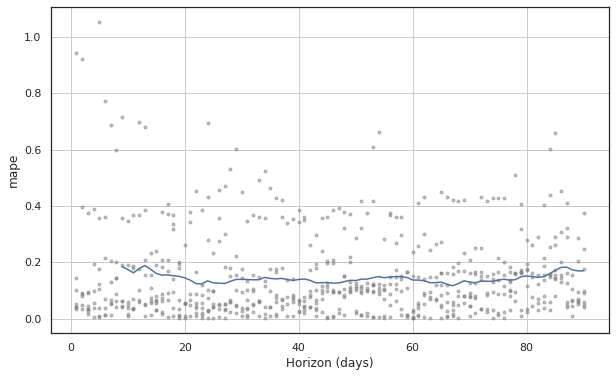

In [39]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

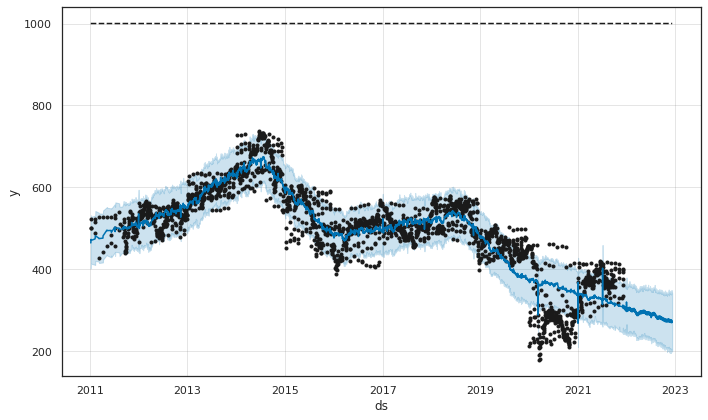

In [40]:
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
fcst = m.predict(future)
fig = m.plot(fcst)